# Text Generation using LSTM Seq-to-Seq Network

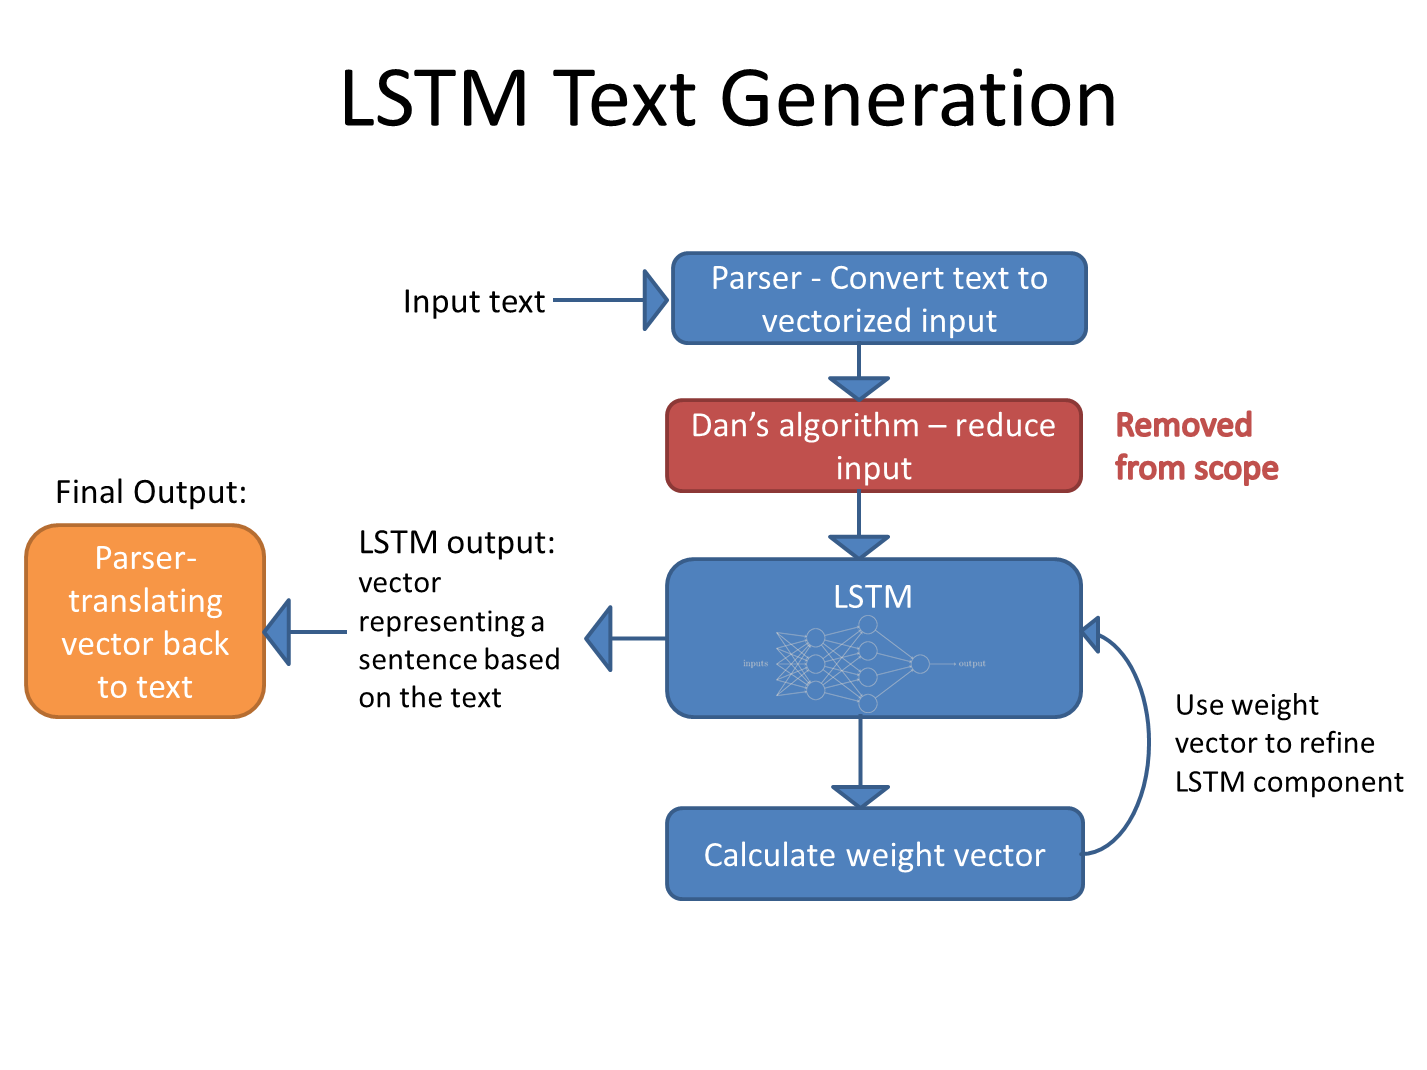

**Importing Needed Libraries**

In [ ]:
import numpy as np 
import pandas as pd
import os 
import re 
import string
import matplotlib.pyplot as plt
import joblib

# from sklearn.feature_extraction.text import tfidffVectorizer

# from sklearn.model_selection improt train_test_split 

# from sklearn.svm import SVC

import nltk

from nltk.tokenize import word_tokenize

from nltk.stem import PorterStemmer

from nltk.corpus import stopwords


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
### Variables and Definitions

RS = 108 ## Random State

Col_Map = 'copper'  ##color map

# porterstemm = PorterStemmer()

stopwords_EN = stopwords.words('english')


curr_path = "/content/drive/MyDrive/NLP/NLP"

In [ ]:
headlines = []

for filename in os.listdir(curr_path):  # iterating filename in rthe current file path  

  if "Articles" in filename:  # if Articles in filename

    article_df = pd.read_csv(curr_path + "/" + filename) # if above condition is true the that specific CSV file are read into a dataframe article df

    headlines.extend(list(article_df["headline"].values)) # all the headlines present the ["headlines"] columns of the csv files in collected in 'headlines' list

    # break

headlines = [h for h in headlines if h != "Unknown"] # only keep headlines that are real headlines not a taglike UnKnown(unavailable)
print("The number of headlines is = ",len(headlines))  # length of headlines list

The number of headlines is =  8027


In [ ]:
headlines

['Finding an Expansive View  of a Forgotten People in Niger',
 'And Now,  the Dreaded Trump Curse',
 'Venezuela’s Descent Into Dictatorship',
 'Stain Permeates Basketball Blue Blood',
 'Taking Things for Granted',
 'The Caged Beast Awakens',
 'An Ever-Unfolding Story',
 'O’Reilly Thrives as Settlements Add Up',
 'Mouse Infestation',
 'Divide in G.O.P. Now Threatens Trump Tax Plan',
 'Variety Puzzle: Acrostic',
 'They Can Hit a Ball 400 Feet. But Play Catch? That’s Tricky.',
 'In Trump Country, Shock at Trump Budget Cuts',
 'Why Is This Hate Different From All Other Hate?',
 'Pick Your Favorite Ethical Offender',
 'My Son’s Growing Black Pride',
 'Jerks and the Start-Ups They Ruin',
 'Trump  Needs  a Brain',
 'Manhood in the Age of Trump',
 'The Value of a Black College',
 'Initial Description',
 'Rough Estimates',
 'El Pasatiempo Nacional',
 'Cooling Off on a Hot Day at Yankee Stadium',
 'Trump’s Staff Mixed Politics and Paydays',
 'A Virtuoso Rebuilding Act Requires Everyone in Tune',

In [ ]:
article_df # the dataframe

,abstract,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,NaN,5906b3197c459f24986dd003,2412,By IAN JOHNSON,article,My Beijing: The Sacred City,"['Travel and Vacations', 'Beijing (China)', 'R...",3,Travel,1,2017-05-01 04:01:21,Unknown,"This metropolis was once a total work of art, ...",The New York Times,News,https://www.nytimes.com/2017/05/01/travel/beij...
1,NaN,5906b3297c459f24986dd004,2318,By EMMA G. FITZSIMMONS,article,"6 Million Riders a Day, 1930s Technology","['Subways', 'Delays (Transportation)', 'Transi...",68,Metro,1,2017-05-01 04:01:33,Unknown,New York’s subway is struggling with old infra...,The New York Times,News,https://www.nytimes.com/2017/05/01/nyregion/ne...
2,NaN,5906ceec7c459f24986dd021,1795,By MARC TRACY,article,Seeking a Cross-Border Conference,"['Cetys University', 'College Athletics', 'Nat...",3,Sports,1,2017-05-01 06:00:05,Unknown,Cetys University is making an ambitious bid to...,The New York Times,News,https://www.nytimes.com/2017/05/01/sports/mexi...
3,NaN,5906cfa77c459f24986dd022,213,By SHANNON DOYNE,article,"Questions for: ‘Despite the “Yuck Factor,” Lee...",[],3,Learning,0,2017-05-01 06:03:03,Unknown,How are leeches used to treat various medical ...,The New York Times,News,https://www.nytimes.com/2017/05/01/learning/qu...
4,NaN,5906e1c07c459f24986dd039,1342,By JASON STANLEY,article,Who Is a ‘Criminal’?,"['Illegal Immigration', 'Traffic and Parking V...",3,OpEd,0,2017-05-01 07:20:26,Unknown,Justice Roberts was right. The Trump administr...,The New York Times,Op-Ed,https://www.nytimes.com/2017/05/01/opinion/who...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,NaN,593087d17c459f24986e2ed8,609,By DEB AMLEN,article,"Yes, You Can Write More Than One Letter in a S...",['Crossword Puzzles'],65,Games,0,2017-06-01 21:31:55,Unknown,Rebuses are crossword elements where solvers a...,The New York Times,News,https://www.nytimes.com/2017/06/01/crosswords/...
992,NaN,59308fdc7c459f24986e2ef2,797,By PAUL KRUGMAN,article,Trump’s Act Of Gratuitous Destruction,"['United States Economy', 'United Nations Fram...",3,OpEd,25,2017-06-01 22:06:15,Unknown,"To the president and the right, it’s all about...",The New York Times,Op-Ed,https://www.nytimes.com/2017/06/01/opinion/tru...
993,NaN,5930a48f7c459f24986e2f24,945,By GINIA BELLAFANTE,article,"Petty Crime, Daunting Bail","['Bail', 'Robberies and Thefts', 'Poverty', 'L...",3,Metropolitan,1,2017-06-01 23:34:14,Unknown,Using conflict resolution and social services ...,The New York Times,News,https://www.nytimes.com/2017/06/01/nyregion/ge...
994,NaN,5930aa877c459f24986e2f2a,141,By BARBARA BOLTON,article,Unknown,"['Bay Ridge (Brooklyn, NY)']",0,Metro,22,2017-06-02 00:00:04,Unknown,A bus rider wants a tale to conclude before he...,The New York Times,News,https://www.nytimes.com/2017/06/01/nyregion/me...


In [ ]:
import string 
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore',category=FutureWarning)

def clean_text(headline):
  text = "".join(word for word in headline if word not in string.punctuation).lower() # Punctuation Removal
  text = text.encode('utf8').decode("ascii",'ignore') # text encoded to 'utf8'
  return text

corpus = [clean_text(headline) for headline in headlines] # created a corpus using the headlines passed through the clean_text function to clean the data
corpus

['finding an expansive view  of a forgotten people in niger',
 'and now  the dreaded trump curse',
 'venezuelas descent into dictatorship',
 'stain permeates basketball blue blood',
 'taking things for granted',
 'the caged beast awakens',
 'an everunfolding story',
 'oreilly thrives as settlements add up',
 'mouse infestation',
 'divide in gop now threatens trump tax plan',
 'variety puzzle acrostic',
 'they can hit a ball 400 feet but play catch thats tricky',
 'in trump country shock at trump budget cuts',
 'why is this hate different from all other hate',
 'pick your favorite ethical offender',
 'my sons growing black pride',
 'jerks and the startups they ruin',
 'trump  needs  a brain',
 'manhood in the age of trump',
 'the value of a black college',
 'initial description',
 'rough estimates',
 'el pasatiempo nacional',
 'cooling off on a hot day at yankee stadium',
 'trumps staff mixed politics and paydays',
 'a virtuoso rebuilding act requires everyone in tune',
 'homeland seaso

In [ ]:
# In below lines of code we splitted the headings and fetched out the words in seperated in the list vocabulary 
vocab = []
for line in corpus:
  words = line.split()
  for word in words:
    vocab.append(word)

vocabulary = set(vocab)
vocabulary

{'couch',
 'cracking',
 'wed',
 'foreigners',
 'complicit',
 'worries',
 'syrias',
 'slogs',
 'explored',
 'bulletproof',
 'caution',
 'rescued',
 'explosions',
 'podiums',
 'motto',
 'wideman',
 'growers',
 'bend',
 'brutish',
 'stairs',
 'signatures',
 'types',
 'scoops',
 'ruth',
 'advocacy',
 'matches',
 'foresight',
 'grades',
 'rebels',
 'trapped',
 'chronicle',
 'highways',
 'nearby',
 'vanguard',
 'blasting',
 'jolt',
 'lowest',
 'unarmed',
 'conscious',
 'glenn',
 'liable',
 'shakeup',
 'buggy',
 'rugged',
 'songs',
 '29',
 'obit',
 'beside',
 'los',
 'grade',
 'understand',
 'cystic',
 'craze',
 'birth',
 'chattanooga',
 'value',
 'delicacy',
 'h1b',
 'seats',
 'q',
 'aaron',
 'crawling',
 'honorable',
 'repealed',
 'oreilly',
 'tuning',
 'schoolhouse',
 '2127',
 'rivers',
 'rankings',
 'invaded',
 'assistants',
 'brooklynite',
 'edward',
 'lush',
 'bowl',
 'classrooms',
 'caveats',
 'overheat',
 'vacancies',
 'destructive',
 'switch',
 'missions',
 'mta',
 'hayden',
 'badger

In [ ]:
len(vocabulary)

10778

In [ ]:
len(vocab)

56105

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [ ]:
tokenizer = Tokenizer() # initialized the tokenizer() object to tokenize the text
tokenizer.fit_on_texts(corpus) # fitted the tikenizer() on the corpus
word2index = tokenizer.word_index # mapped words to their respective indices using .word_index
len(word2index)

10778

In [ ]:
word2index

{'the': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'for': 6,
 'and': 7,
 'on': 8,
 'is': 9,
 'trump': 10,
 'with': 11,
 'new': 12,
 'at': 13,
 'how': 14,
 'what': 15,
 'you': 16,
 'an': 17,
 'from': 18,
 'trumps': 19,
 'as': 20,
 'it': 21,
 'its': 22,
 'are': 23,
 'your': 24,
 'not': 25,
 'be': 26,
 'us': 27,
 'season': 28,
 'that': 29,
 'by': 30,
 'but': 31,
 'about': 32,
 'can': 33,
 'episode': 34,
 'do': 35,
 'york': 36,
 'when': 37,
 'up': 38,
 'this': 39,
 'why': 40,
 'over': 41,
 'no': 42,
 'i': 43,
 'out': 44,
 'more': 45,
 'my': 46,
 'after': 47,
 'will': 48,
 'may': 49,
 'health': 50,
 'we': 51,
 'or': 52,
 'war': 53,
 'questions': 54,
 'his': 55,
 'who': 56,
 'today': 57,
 'now': 58,
 'president': 59,
 'house': 60,
 'should': 61,
 'teaching': 62,
 'have': 63,
 'get': 64,
 'one': 65,
 'was': 66,
 'into': 67,
 'all': 68,
 'dont': 69,
 'home': 70,
 'good': 71,
 'plan': 72,
 'life': 73,
 'our': 74,
 'gop': 75,
 'has': 76,
 'says': 77,
 'like': 78,
 'first': 79,
 'white': 80,
 'tr

In [ ]:
# created two dictionaries ,'dictionary' -> to map words to their respective indices  and 'rev_dictionary' -> to map indices to their respective words
dictionary={}
rev_dictionary={}
for word,idx in word2index.items():
    dictionary[word]=idx
    rev_dictionary[idx]=word
    
    max(rev_dictionary.keys())
    
dictionary

{'the': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'for': 6,
 'and': 7,
 'on': 8,
 'is': 9,
 'trump': 10,
 'with': 11,
 'new': 12,
 'at': 13,
 'how': 14,
 'what': 15,
 'you': 16,
 'an': 17,
 'from': 18,
 'trumps': 19,
 'as': 20,
 'it': 21,
 'its': 22,
 'are': 23,
 'your': 24,
 'not': 25,
 'be': 26,
 'us': 27,
 'season': 28,
 'that': 29,
 'by': 30,
 'but': 31,
 'about': 32,
 'can': 33,
 'episode': 34,
 'do': 35,
 'york': 36,
 'when': 37,
 'up': 38,
 'this': 39,
 'why': 40,
 'over': 41,
 'no': 42,
 'i': 43,
 'out': 44,
 'more': 45,
 'my': 46,
 'after': 47,
 'will': 48,
 'may': 49,
 'health': 50,
 'we': 51,
 'or': 52,
 'war': 53,
 'questions': 54,
 'his': 55,
 'who': 56,
 'today': 57,
 'now': 58,
 'president': 59,
 'house': 60,
 'should': 61,
 'teaching': 62,
 'have': 63,
 'get': 64,
 'one': 65,
 'was': 66,
 'into': 67,
 'all': 68,
 'dont': 69,
 'home': 70,
 'good': 71,
 'plan': 72,
 'life': 73,
 'our': 74,
 'gop': 75,
 'has': 76,
 'says': 77,
 'like': 78,
 'first': 79,
 'white': 80,
 'tr

In [ ]:
rev_dictionary

{1: 'the',
 2: 'a',
 3: 'to',
 4: 'of',
 5: 'in',
 6: 'for',
 7: 'and',
 8: 'on',
 9: 'is',
 10: 'trump',
 11: 'with',
 12: 'new',
 13: 'at',
 14: 'how',
 15: 'what',
 16: 'you',
 17: 'an',
 18: 'from',
 19: 'trumps',
 20: 'as',
 21: 'it',
 22: 'its',
 23: 'are',
 24: 'your',
 25: 'not',
 26: 'be',
 27: 'us',
 28: 'season',
 29: 'that',
 30: 'by',
 31: 'but',
 32: 'about',
 33: 'can',
 34: 'episode',
 35: 'do',
 36: 'york',
 37: 'when',
 38: 'up',
 39: 'this',
 40: 'why',
 41: 'over',
 42: 'no',
 43: 'i',
 44: 'out',
 45: 'more',
 46: 'my',
 47: 'after',
 48: 'will',
 49: 'may',
 50: 'health',
 51: 'we',
 52: 'or',
 53: 'war',
 54: 'questions',
 55: 'his',
 56: 'who',
 57: 'today',
 58: 'now',
 59: 'president',
 60: 'house',
 61: 'should',
 62: 'teaching',
 63: 'have',
 64: 'get',
 65: 'one',
 66: 'was',
 67: 'into',
 68: 'all',
 69: 'dont',
 70: 'home',
 71: 'good',
 72: 'plan',
 73: 'life',
 74: 'our',
 75: 'gop',
 76: 'has',
 77: 'says',
 78: 'like',
 79: 'first',
 80: 'white',
 81:

In [ ]:
input_sequences = tokenizer.texts_to_sequences(corpus)  # created input sequences by .text_to_sequences(corpus) that gave headlines in format of a list containing of words indices in proper order of the 
                                                        # headlines only 
                                                        # foe eg a headline is [betting on the berkshires] lets suppose just for understanding the indices of words in the headline in the eg are [45,57,809,111]
                                                        # then the input sequence will be [45,57,809,111]
input_sequences

[[354, 17, 4909, 515, 4, 2, 2340, 126, 5, 1826],
 [7, 58, 1, 4910, 10, 4911],
 [3181, 4912, 67, 3182],
 [2341, 4913, 1827, 605, 405],
 [261, 355, 6, 2342],
 [1, 4914, 2343, 2344],
 [17, 4915, 187],
 [1267, 3183, 20, 3184, 743, 38],
 [4916, 4917],
 [841, 5, 75, 58, 1828, 10, 132, 72],
 [120, 356, 326],
 [104, 33, 842, 2, 2345, 4918, 1490, 31, 302, 2346, 481, 1829],
 [5, 10, 382, 1073, 13, 10, 303, 357],
 [40, 9, 39, 437, 606, 18, 68, 272, 437],
 [482, 24, 383, 2347, 1830],
 [46, 1268, 941, 105, 1269],
 [4919, 7, 1, 3185, 104, 1270],
 [10, 358, 2, 555],
 [3186, 5, 1, 238, 4, 10],
 [1, 1074, 4, 2, 105, 221],
 [4920, 3187],
 [1491, 3188],
 [1492, 4921, 4922],
 [3189, 135, 8, 2, 556, 127, 13, 4923, 3190],
 [19, 942, 1831, 203, 7, 3191],
 [2, 4924, 3192, 327, 4925, 673, 5, 843],
 [516, 28, 123, 34, 943, 9, 1832, 106, 2, 1493, 1833],
 [89, 164, 944, 7, 1, 239, 4, 1834],
 [2348, 2, 4926],
 [483, 1075, 7, 1271, 34, 149, 261, 1, 945],
 [359, 28, 90, 34, 222, 3193, 9, 71, 1835, 37, 22, 25],
 [124

In [ ]:
# in the below lines of code we have created the input data as the full input_sequence except the last element b'coz that's the on ting that our madel will predict
# for eg . jonny is a good boy 
# in here [0      1 2   3   4] <- input_sequence 
# and our input data will be "jonny is a good will" an the word "boy" our model will predict
# so [0,1,2,4] will be input data and [4] is the target 

input_data = []

target = []

for line in input_sequences:

  for i in range(1, len(line) - 1):

    input_data.append(line[:i])

    target.append(line [i])

In [ ]:
input_data

[[354],
 [354, 17],
 [354, 17, 4909],
 [354, 17, 4909, 515],
 [354, 17, 4909, 515, 4],
 [354, 17, 4909, 515, 4, 2],
 [354, 17, 4909, 515, 4, 2, 2340],
 [354, 17, 4909, 515, 4, 2, 2340, 126],
 [7],
 [7, 58],
 [7, 58, 1],
 [7, 58, 1, 4910],
 [3181],
 [3181, 4912],
 [2341],
 [2341, 4913],
 [2341, 4913, 1827],
 [261],
 [261, 355],
 [1],
 [1, 4914],
 [17],
 [1267],
 [1267, 3183],
 [1267, 3183, 20],
 [1267, 3183, 20, 3184],
 [841],
 [841, 5],
 [841, 5, 75],
 [841, 5, 75, 58],
 [841, 5, 75, 58, 1828],
 [841, 5, 75, 58, 1828, 10],
 [120],
 [104],
 [104, 33],
 [104, 33, 842],
 [104, 33, 842, 2],
 [104, 33, 842, 2, 2345],
 [104, 33, 842, 2, 2345, 4918],
 [104, 33, 842, 2, 2345, 4918, 1490],
 [104, 33, 842, 2, 2345, 4918, 1490, 31],
 [104, 33, 842, 2, 2345, 4918, 1490, 31, 302],
 [104, 33, 842, 2, 2345, 4918, 1490, 31, 302, 2346],
 [5],
 [5, 10],
 [5, 10, 382],
 [5, 10, 382, 1073],
 [5, 10, 382, 1073, 13],
 [5, 10, 382, 1073, 13, 10],
 [40],
 [40, 9],
 [40, 9, 39],
 [40, 9, 39, 437],
 [40, 9, 39,

In [ ]:
target

[17,
 4909,
 515,
 4,
 2,
 2340,
 126,
 5,
 58,
 1,
 4910,
 10,
 4912,
 67,
 4913,
 1827,
 605,
 355,
 6,
 4914,
 2343,
 4915,
 3183,
 20,
 3184,
 743,
 5,
 75,
 58,
 1828,
 10,
 132,
 356,
 33,
 842,
 2,
 2345,
 4918,
 1490,
 31,
 302,
 2346,
 481,
 10,
 382,
 1073,
 13,
 10,
 303,
 9,
 39,
 437,
 606,
 18,
 68,
 272,
 24,
 383,
 2347,
 1268,
 941,
 105,
 7,
 1,
 3185,
 104,
 358,
 2,
 5,
 1,
 238,
 4,
 1074,
 4,
 2,
 105,
 4921,
 135,
 8,
 2,
 556,
 127,
 13,
 4923,
 942,
 1831,
 203,
 7,
 4924,
 3192,
 327,
 4925,
 673,
 5,
 28,
 123,
 34,
 943,
 9,
 1832,
 106,
 2,
 1493,
 164,
 944,
 7,
 1,
 239,
 4,
 2,
 1075,
 7,
 1271,
 34,
 149,
 261,
 1,
 28,
 90,
 34,
 222,
 3193,
 9,
 71,
 1835,
 37,
 22,
 112,
 8,
 5,
 39,
 195,
 1272,
 88,
 16,
 557,
 1273,
 3194,
 30,
 170,
 52,
 674,
 5,
 273,
 17,
 1076,
 607,
 32,
 24,
 4927,
 4,
 744,
 13,
 9,
 4928,
 44,
 8,
 3195,
 3196,
 4,
 66,
 4930,
 4931,
 2349,
 18,
 111,
 136,
 3198,
 360,
 121,
 6,
 608,
 675,
 274,
 846,
 2350,
 3200,
 67,

In [ ]:
len(input_data)

40113

In [ ]:
len(target)

40113

In [ ]:
# below code extracted the maximum length of a headline(sentence) present in the input_data , o/p is 22 that means the largest headline is 22 words long
MAX_LEN = 0
for seq in input_data:
  if len(seq) > MAX_LEN:
    MAX_LEN = len(seq)
MAX_LEN

22

In [ ]:

## pad_sequences function

# Pads sequences to the same length. This function transforms a list (of length num_samples ) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps) . 
# num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.

input_data = pad_sequences(input_data, maxlen = MAX_LEN, padding = "post", truncating = "post")

In [ ]:
input_data.shape

(40113, 22)

In [ ]:
input_data

array([[ 354,    0,    0, ...,    0,    0,    0],
       [ 354,   17,    0, ...,    0,    0,    0],
       [ 354,   17, 4909, ...,    0,    0,    0],
       ...,
       [4347,   10,  318, ...,    0,    0,    0],
       [4347,   10,  318, ...,    0,    0,    0],
       [4347,   10,  318, ...,    0,    0,    0]], dtype=int32)

In [ ]:
target = to_categorical(target, num_classes = len(word2index)) # targets a re converted to categorical datatype

In [ ]:
target.shape

(40113, 10778)

In [ ]:
target 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# imports required for building the model

from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential() # Sequential mode initialization

model.add(Embedding(input_dim = len(vocabulary), output_dim = 100, input_length = MAX_LEN)) # here embedding layer does the work of one hot encoding but when the data is large and the categories are 
                                                                                            # large in number the we use the in-built embedding layer 
                                                                                            # input_dim = no. of categories in our case it is the total number of unique words present in the 
                                                                                            # corpus of sorts
                                                                                            # output_dim = no. of vectors you wish to return (100 columns in our case , that's the thing about embedding 
                                                                                            # layer it gives us freedom to decide the numbe of vectors in which we wanna encode our target varable data)
model.add(LSTM(units = 100)) # LSTM with 100 Units 

model.add(Dropout(rate = 0.1)) # Dropout with dropout rate 0.1 i.e. 10% to avoid overfitting of our model

model.add(Dense(units = target.shape[1],activation = "softmax")) # Output layer with shape of target data vector and activation function set to "softmax" b'coz it'll give probabilities of the all 
                                                                 # the words that are potentially the actual word thst is to be predicted



In [ ]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 100)           1077800   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 10778)             1088578   
                                                                 
Total params: 2,246,778
Trainable params: 2,246,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model Compilation
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
# Fitting the model on our data|
model.fit(input_data, target, batch_size = 50, epochs = 100)

Epoch 1/100
803/803 [==============================] - 7s 8ms/step - loss: 3.7286 - accuracy: 0.2976
Epoch 2/100
803/803 [==============================] - 6s 8ms/step - loss: 3.6675 - accuracy: 0.3058
Epoch 3/100
803/803 [==============================] - 6s 8ms/step - loss: 3.6106 - accuracy: 0.3118
Epoch 4/100
803/803 [==============================] - 6s 8ms/step - loss: 3.5541 - accuracy: 0.3208
Epoch 5/100
803/803 [==============================] - 6s 8ms/step - loss: 3.4987 - accuracy: 0.3245
Epoch 6/100
803/803 [==============================] - 6s 8ms/step - loss: 3.4367 - accuracy: 0.3349
Epoch 7/100
803/803 [==============================] - 7s 9ms/step - loss: 3.3895 - accuracy: 0.3405
Epoch 8/100
803/803 [==============================] - 6s 8ms/step - loss: 3.3351 - accuracy: 0.3473
Epoch 9/100
803/803 [==============================] - 6s 8ms/step - loss: 3.2738 - accuracy: 0.3574
Epoch 10/100
803/803 [==============================] - 6s 8ms/step - loss: 3.2215 - accura

# Generating the text

In [ ]:
import tensorflow
from numpy.random import seed
tensorflow.random.set_seed(2)
seed(1)

In [ ]:
def text_generater(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding="post")
        #predicted = model.predict_classes(token_list, verbose=0)
        predicted=model.predict(token_list) 
        predicted=np.argmax(predicted,axis=1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()
    

In [ ]:
text1 = "Trump decided"
text_generater(text1, 5, model, MAX_LEN)

1/1 [==============================] - 0s 16ms/step


'Trump Decided Blocks A Absence Bid Resigns'

# Model Using GRU

In [ ]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim=len(vocabulary), output_dim=100, input_length=MAX_LEN))
gru_model.add(GRU(units=100))
gru_model.add(Dropout(rate=0.1))
gru_model.add(Dense(units=target.shape[1], activation="softmax"))

In [ ]:
# GRU Model Compilationg
gru_model.compile(loss="categorical_crossentropy", optimizer="adam")


In [ ]:
gru_model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 22, 100)           1077800   
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10778)             1088578   
                                                                 
Total params: 2,226,978
Trainable params: 2,226,978
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_model.fit(input_data, target, batch_size=10, epochs=100, verbose=1)


Epoch 1/100
4012/4012 [==============================] - 23s 5ms/step - loss: 7.6375
Epoch 2/100
4012/4012 [==============================] - 21s 5ms/step - loss: 7.0675
Epoch 3/100
4012/4012 [==============================] - 20s 5ms/step - loss: 6.7344
Epoch 4/100
4012/4012 [==============================] - 21s 5ms/step - loss: 6.4430
Epoch 5/100
4012/4012 [==============================] - 20s 5ms/step - loss: 6.1608
Epoch 6/100
4012/4012 [==============================] - 20s 5ms/step - loss: 5.8703
Epoch 7/100
4012/4012 [==============================] - 20s 5ms/step - loss: 5.5800
Epoch 8/100
4012/4012 [==============================] - 21s 5ms/step - loss: 5.2957
Epoch 9/100
4012/4012 [==============================] - 20s 5ms/step - loss: 5.0178
Epoch 10/100
4012/4012 [==============================] - 20s 5ms/step - loss: 4.7488
Epoch 11/100
4012/4012 [==============================] - 21s 5ms/step - loss: 4.5015
Epoch 12/100
4012/4012 [==============================] - 20s 5

In [ ]:
text1 = "Trump decided"
text_generater(text1, 5, gru_model, MAX_LEN)


1/1 [==============================] - 0s 16ms/step


'Trump Decided To Stay At A Bigger'